# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 2C
+ 2D
+ 2E
+ S2D
+ S2E
+ S2F
+ S2G
+ S2H
+ S2I
+ S2J
+ S2K

#### Archives:
+ Transcription_naked-DNA_ATP_LD555.yama
+ Transcription_naked-DNA_ATPgS_LD555.yama
+ Transcription_naked-DNA_ATP_LD655.yama
+ Transcription_naked-DNA_ATP_AF488.yama
+ Transcription_ORC-DNA_ATP.yama
+ Transcription_naked-DNA_T7T_ATP.yama
+ Transcription_ORC-DNA_T7T_ATP.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from scipy.stats import norm
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_naked-DNA_ATP_LD555.yama',
                     'Transcription_naked-DNA_ATPgS_LD555.yama',
                     'Transcription_naked-DNA_ATP_LD655.yama',
                     'Transcription_naked-DNA_ATP_AF488.yama',
                     'Transcription_ORC-DNA_ATP.yama',
                     'Transcription_naked-DNA_T7T_ATP.yama',
                     'Transcription_ORC-DNA_T7T_ATP.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure2/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure2/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_naked-DNA_ATP_LD555,6,303,ybbR-LD555-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATPgS_LD555,3,224,ybbR-LD555-T7,ATPgS,False,n/a,False,passed
Transcription_naked-DNA_ATP_LD655,1,281,ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATP_AF488,1,129,SNAP-AF488-T7,ATP,False,n/a,False,passed
Transcription_ORC-DNA_ATP,1,206,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_T7T_ATP,1,325,ybbR-LD655-T7,ATP,False,n/a,True,passed
Transcription_ORC-DNA_T7T_ATP,3,612,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    # filter for t7 prefixes here
    col_1 = sorted(list(filter(lambda prefix: re.match('T7_', prefix),prefixes)))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        
        # exclude all DNA molecules which have other proteins than T7
        if (molecule.proteins['T7'] != 1 or sum(molecule.proteins.values()) != 1):
            continue
            
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:10][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
            df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()

            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")            
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                           T7_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
ccL73X2LZs3oo8Brd9uXBw          15884.20       52             0      NaN   
oym98bkVBrGwovduW56PUa           7397.85       48             0      NaN   
x9g55cLvkv8o8iBT3nKsqN          14752.75       52             0      NaN   
maGCAQALHwthvvGp6tDnBo          17400.90       79             0      NaN   
fHbm1hNUhJPZaESvyWR68Q          16200.95       15             0      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
ccL73X2LZs3oo8Brd9uXBw             NaN      NaN      NaN             NaN   
oym98bkVBrGwovduW56PUa             NaN      NaN      NaN             NaN   
x9g55cLvkv8o8iBT3nKsqN             NaN      NaN      NaN             NaN   
maGCAQALHwthvvGp6tDnBo             NaN      NaN      NaN             NaN   
fHbm1hNUhJPZaESvyWR68Q             NaN      NaN      NaN             NaN   

molecule                                      ... dna_length hs_wash  \
properties                        start_site  ...                      
properties_details     recovery               ...                      
ccL73X2LZs3oo8Brd9uXBw      NaN  2509.375508  ...  36.445558   False   
oym98bkVBrGwovduW56PUa      NaN  1978.278427  ...  33.530995   False   
x9g55cLvkv8o8iBT3nKsqN      NaN  2750.074100  ...  33.937461   False   
maGCAQALHwthvvGp6tDnBo      NaN  2001.222394  ...  33.582015   False   
fHbm1hNUhJPZaESvyWR68Q      NaN  3479.312937  ...  34.134637   False   

molecule               label_ORC    label_T7 nucleotide number_ORC number_T7  \
properties                                                                     
properties_details                                                             
ccL73X2LZs3oo8Brd9uXBw       NaN  ybbR-LD555        ATP        NaN       1.0   
oym98bkVBrGwovduW56PUa       NaN  ybbR-LD555        ATP        NaN       1.0   
x9g55cLvkv8o8iBT3nKsqN       NaN  ybbR-LD555        ATP        NaN       1.0   
maGCAQALHwthvvGp6tDnBo       NaN  ybbR-LD555        ATP        NaN       1.0   
fHbm1hNUhJPZaESvyWR68Q       NaN  ybbR-LD555        ATP        NaN       1.0   

molecule               t7_terminator      tags velocity_T7  
properties                                                  
properties_details                                          
ccL73X2LZs3oo8Brd9uXBw         False  [accept]   56.381446  
oym98bkVBrGwovduW56PUa         False  [accept]   60.487916  
x9g55cLvkv8o8iBT3nKsqN         False  [accept]   60.593727  
maGCAQALHwthvvGp6tDnBo         False  [accept]   55.902532  
fHbm1hNUhJPZaESvyWR68Q         False  [accept]   53.811622  

[5 rows x 21 columns]

## Figures

### Figure 2C: Transcription start & stop sites
*Note*: only consider DNA w/o T7T

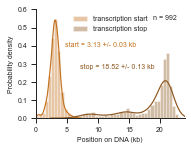

In [14]:
protein = 'T7'

fig,axes = plt.subplots()

sns.distplot(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000,ax=axes,
            label='transcription start',color=palettes[protein][1],bins = np.linspace(0, 25, 51))
# mean+/- sem
mean_start = pd.melt(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].mean()
sem_start = pd.melt(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].sem()
axes.text(0.2, 0.7, f"start = {round(mean_start,2)} +/- {round(sem_start,2)} kb",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,color=palettes[protein][1])

sns.distplot(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('stop_site',level='properties',axis=1)/1000,ax=axes,
            label='transcription stop',color=palettes[protein][3],bins = np.linspace(0, 25, 51))

# mean+/- sem
mean_stop = pd.melt(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('stop_site',level='properties',axis=1)/1000)['value'].mean()
sem_stop = pd.melt(df[~df['t7_terminator']].filter(regex=(protein+"_"),axis=1).xs('stop_site',level='properties',axis=1)/1000)['value'].sem()
axes.text(0.8, 0.5, f"stop = {round(mean_stop,2)} +/- {round(sem_stop,2)} kb",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,color=palettes[protein][3])

axes.set_xlim(0,24)
axes.set_ylim(0,0.6)
axes.set_xlabel('Position on DNA (kb)')
axes.set_ylabel('Probability density')
axes.legend(loc=9,frameon=False)

#plt.title('T7 RNAP is very processive (> 15 kb)')

axes.text(0.95, 0.95, f"n = {int(df[~df['t7_terminator']]['number_T7'].sum())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'2C_Transcription_start_stop_sites.svg',transparent=True)

### Figure 2D: Transcription rates (ATP vs ATPgS)

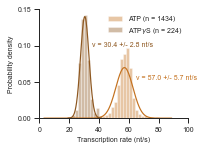

In [15]:
protein = 'T7'

fig,axes = plt.subplots()

sns.distplot(df[df['nucleotide']=='ATP']['velocity_T7'],
             ax=axes,label=f"ATP (n = {int(df[df['nucleotide']=='ATP']['number_T7'].sum())})",
             color=palettes[protein][1],bins = np.linspace(0, 100, 51), kde=False, fit=norm,
             fit_kws = {'color':palettes[protein][1]})
mu, std = norm.fit(df[df['nucleotide']=='ATP']['velocity_T7'])

axes.text(0.65, 0.4, f"v = {round(mu,1)} +/- {round(std,1)} nt/s",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,color=palettes[protein][1])

sns.distplot(df[df['nucleotide']=='ATPgS']['velocity_T7'],
             ax=axes,label=f"ATP$\gamma$S (n = {int(df[df['nucleotide']=='ATPgS']['number_T7'].sum())})",
             color=palettes[protein][3],bins = np.linspace(0, 100, 51), kde=False, fit=norm,
             fit_kws = {'color':palettes[protein][3]})

mu, std = norm.fit(df[df['nucleotide']=='ATPgS']['velocity_T7'])

axes.text(0.35, 0.7, f"v = {round(mu,1)} +/- {round(std,1)} nt/s",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,color=palettes[protein][3])


axes.set_xlim(0,100)
#axes.set_ylim(0,23)
axes.set_xlabel('Transcription rate (nt/s)')
axes.set_ylabel('Probability density')
axes.legend(loc=0,frameon=False)
axes.set_yticks([0,0.05,0.1,0.15])
#plt.title('T7 RNAP accepts ATP$\gamma$s but rates are reduced')

sns.despine(trim=True)
#plt.tight_layout()

plt.savefig(dir_out+'2D_Transcription_rates_hueNuc.svg',transparent=True)

### Figure 2E: Pause frequency (ATP vs ATPgS)
*Note*: only consider DNA w/o T7T

In [16]:
# estimate standard error by bootstrapping

In [17]:
_plot_df = pd.DataFrame(columns=['nucleotide','# of pauses'])
protein = 'T7'

for nuc in df['nucleotide'].unique():
    for num_pause in range(1,int(pd.melt(df[~df['t7_terminator']].filter(regex=("T7_"),axis=1)
                                         .xs('number_pauses',level='properties',axis=1))['value'].max())+1):
        # figure out total nobs
        nobs = len(df[(~df['t7_terminator']) & (df['nucleotide']==nuc)])
        
        _temp_df = pd.DataFrame(data=([nobs]))
        _temp_df.columns = ['nobs']
        _temp_df['nucleotide'] = nuc
        _temp_df['# of pauses'] = num_pause
        
        #if pause available calculate probability
        try:
            #set to value divided by total value
            probability = df[(~df['t7_terminator']) & (df['nucleotide']==nuc)][('T7_1_','number_pauses')].value_counts()[num_pause]/nobs
        #if pause not available set probability to 0 (KeyError)
        except KeyError:
            probability = 0
        _temp_df['probability'] = probability
        
        # bootstrapping
        # generate list with #1 * probability and #0*(1-probability)*dna_number
        bootstrap_data = ([0 for _ in range(int((1-probability)*nobs))] +
                          [1 for _ in range(int(probability*nobs))])
        
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        _temp_df['bs_mean'] = np.mean(bootstrap_means)
        _temp_df['standard_error'] = np.std(bootstrap_means)
        _temp_df['68_ci_lower'], _temp_df['68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
        _temp_df['95_ci_lower'], _temp_df['95_ci_upper'] = calc_ci(bootstrap_means,ci=95)

        _plot_df = pd.concat([_plot_df,_temp_df])
        _plot_df = _plot_df.convert_dtypes()
        _plot_df.reset_index(drop=True,inplace=True)

_plot_df

,nucleotide,# of pauses,nobs,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,ATP,1,768,0.111979,0.112202,0.011368,0.100260,0.123698,0.089844,0.135417
1,ATP,2,768,0.006510,0.006511,0.002876,0.003906,0.009115,0.001302,0.013021
2,ATPgS,1,224,0.133929,0.134100,0.022897,0.111607,0.156250,0.089286,0.178571
3,ATPgS,2,224,0.008929,0.008992,0.006357,0.004464,0.013393,0.000000,0.022321


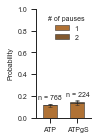

In [18]:
fig,axes = plt.subplots()
protein = 'T7'
_plot_df.groupby(['nucleotide','# of pauses'])['probability'].sum().unstack().loc[
    ['ATP','ATPgS']].plot(kind='bar',width=0.5, figsize=(1,2),stacked=True, ax=axes,lw=0.5, edgecolor='.15',
                                                                                       color=[sns.desaturate(palettes[protein][1],0.75),sns.desaturate(palettes[protein][3],0.75)],
                                                                                       error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                                                                                       yerr=_plot_df.groupby(['nucleotide','# of pauses'])['standard_error'].sum().unstack())
axes.set_ylim(0,1)
axes.set_xlabel(None)
axes.set_ylabel('Probability')
axes.legend(title='# of pauses',frameon=False)
for item in axes.get_xticklabels():
    item.set_rotation(0)

labels = _plot_df.loc[::2,'nobs']

#calculate y offset to label bars on top
dy = _plot_df.loc[::2,'probability']

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    height = dy.iloc[counter]
    axes.text(rect.get_x() + rect.get_width()/2, height+0.05, s=f"n = {label}", ha='center', va='bottom')
    counter+=1
    
sns.despine()


plt.savefig(dir_out+'2E_Transcription_pausefreq_hueNuc.svg',transparent=True)

### Figure S2D: Transcription start & stop sites (ATP vs ATPgS)
*Note*: only consider DNA w/o T7T

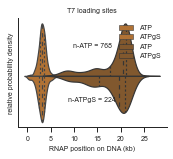

In [19]:
protein = 'T7'

_plot_df = pd.DataFrame(columns=['start_site','stop_site','nucleotide'])

for nuc in df['nucleotide'].unique():
    _temp_df = pd.DataFrame(data=dict(start_site= pd.melt(df[(~df['t7_terminator']) & (df['nucleotide']==nuc)].filter(regex=(protein+"_"),axis=1).xs('start_site',level='properties',axis=1)/1000)['value'].dropna(),
                                  stop_site= pd.melt(df[(~df['t7_terminator']) & (df['nucleotide']==nuc)].filter(regex=(protein+"_"),axis=1).xs('stop_site',level='properties',axis=1)/1000)['value'].dropna()))
    #_temp_df.columns = ['start_site','stop_site']
    _temp_df['nucleotide'] = nuc
    _plot_df = pd.concat([_plot_df,_temp_df])

fig,axes = plt.subplots()

sns.violinplot(x='start_site',y=['dummy_label']*len(_plot_df),hue='nucleotide',data=_plot_df, 
               split=True,inner='quartile', scale='area',ax=axes, palette=palettes[protein][1:2], label='start')

sns.violinplot(x='stop_site',y=['dummy_label']*len(_plot_df),hue='nucleotide',data=_plot_df, 
               split=True,inner='quartile', scale='area',ax=axes, palette=palettes[protein][3:4], label='stop')

axes.set_xlabel('RNAP position on DNA (kb)')
axes.set_ylabel('relative probability density')
axes.set_title(f'{protein} loading sites')
axes.set_yticklabels([])
axes.set_yticks([])
axes.text(0.5, 0.75, f"n-ATP = {len(_plot_df[_plot_df['nucleotide']=='ATP'])}",
        verticalalignment='center', horizontalalignment='center',
        transform=axes.transAxes)
axes.text(0.5, 0.25, f"n-ATPgS = {len(_plot_df[_plot_df['nucleotide']=='ATPgS'])}",
        verticalalignment='center', horizontalalignment='center',
        transform=axes.transAxes)
axes.legend(frameon=False,loc=1)
sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S2D_Transcription_start_stop_sites_hueNuc.svg',transparent=True)
# delete the garbage
del(_temp_df)
del(_plot_df)

### Figure S2E: Representative molecule demonstrating tracking and pause detection

In [20]:
example_molecules_uid = ['iTEmwxiKAPnLoV9CFH2p6M']

example_molecules = []

# grab molecule objects
for uid in example_molecules_uid:
    for archive in DnaMoleculeArchive.instances:
        try:
            example_molecules.append(archive.get_molecule_by_uid(uid))
            break
        except IndexError:
            continue
            

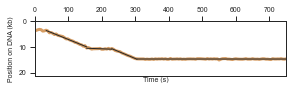

In [21]:
protein = 'T7'
fig,axes=plt.subplots(figsize=(4.5,1),sharex=True,sharey=True)

# find molecule
for i,molecule in enumerate(example_molecules):
    sns.lineplot(x='T7_1_Time (s)', y=molecule.df['T7_1_Position_on_DNA']/1000,data=molecule.df,
                 ax=axes,color=palettes[protein][1],lw=3, alpha=0.7)

    for seg_df in molecule.seg_dfs:
        if seg_df.prefix == 'T7_1_':
            for row in seg_df.df.index:
                temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['x1','y1']].values, seg_df.df.loc[row,['x2','y2']].values],columns=['x','y'])
                sns.lineplot(x='x', y=temp_df['y']/1000,data=temp_df,ax=axes,color='.15',lw=1)
            break
 
       
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'Position on DNA (kb)', va='center', rotation='vertical')
        
axes.set_xlabel(None)
axes.set_ylabel(None)

plt.xticks([0,100,200,300,400,500,600,700])
plt.yticks([0,10,20])
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = True, labeltop=True)
plt.xlim(0,750)
plt.ylim([21.2,0])

#sns.despine(trim=True)

#fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.savefig(dir_out+"S2E_Transcription_pauses_tracking_example.svg",transparent=True)

### Figure S2F: Pause recovery

In [22]:
# estimate standard error by bootstrapping

In [23]:
protein = 'T7'

_plot_df = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+'_'),axis=1).filter(regex=("pause_"),axis=1)
                                      .xs('recovery',level='properties_details',axis=1))['value']
                              .dropna().value_counts(normalize=True).rename('probability')
                              .reset_index().sort_values('index')))
_plot_df.columns = ['pause_recovery','probability']
_plot_df['nobs'] = len(pd.melt(df.filter(regex=(protein+'_'),axis=1).filter(regex=('pause_'),axis=1).xs('recovery',level='properties_details',axis=1))['value'].dropna())
_plot_df = _plot_df.convert_dtypes()
_plot_df.reset_index(drop=True,inplace=True)

_plot_df

,pause_recovery,probability,nobs
0,False,0.591716,169
1,True,0.408284,169


In [24]:
for row in _plot_df.index:
    bootstrap_data = pd.DataFrame(data=(pd.melt(df.filter(regex=(protein+'_'),axis=1).filter(regex=("pause_"),axis=1)
                                      .xs('recovery',level='properties_details',axis=1))['value'].dropna()))
    bootstrap_data['value'] = bootstrap_data['value'].apply(lambda value: 1 if value == _plot_df.loc[row,'pause_recovery'] else 0)
    bootstrap_means = bootstrap(bootstrap_data['value'],n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
_plot_df

,pause_recovery,probability,nobs,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,False,0.591716,169,0.591586,0.037782,0.556213,0.627219,0.514793,0.662722
1,True,0.408284,169,0.407855,0.037862,0.372781,0.443787,0.331361,0.485207


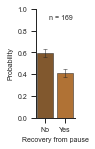

In [25]:
fig,axes = plt.subplots(figsize=(0.7,2))
protein = 'T7'

sns.barplot(x='pause_recovery',y='probability',data=_plot_df, lw=0.5, edgecolor='.15', 
            palette=palettes[protein][3::-2], ax=axes)
axes.errorbar(x='pause_recovery',y='probability',data=_plot_df, yerr='standard_error',fmt='none',
             ecolor='.15', elinewidth=0.5, capsize=2, capthick=0.5, capstyle='round')

axes.set_ylim(0,1)
axes.set_xlabel('Recovery from pause')
axes.set_ylabel('Probability')

axes.text(0.95, 0.95, f"n = {_plot_df.loc[0,'nobs']}",
    verticalalignment='top', horizontalalignment='right',
    transform=axes.transAxes)

axes.set_xticklabels(['No','Yes'])

sns.despine()
#plt.tight_layout()

# save
plt.savefig(dir_out+'S2F_Transcription_pause_recovery.svg',transparent=True)

### Figure S2G: Pause durations (transient pauses only)

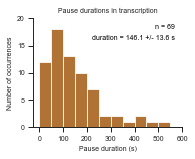

In [26]:
protein = 'T7'

_plot_df = pd.DataFrame(columns=['duration','recovery'])
for index in df.index:
    # check how many pauses we got
    for i in range(1,df.loc[index,('T7_1_','number_pauses','')]+1):
        
        _temp_df = pd.DataFrame(data=[[df.loc[index,('T7_1_','pause_'+str(i),'duration')],
                                      df.loc[index,('T7_1_','pause_'+str(i),'recovery')]]],
                                      columns=['duration','recovery'])
        _plot_df = pd.concat([_plot_df,_temp_df])
    
_plot_df = _plot_df.convert_dtypes()

fig,axes = plt.subplots()

sns.distplot(_plot_df[_plot_df['recovery']]['duration'],
             ax=axes,color=sns.desaturate(palettes[protein][1],0.75),bins = np.linspace(0, 700, 15),kde=False,hist_kws={"alpha": 1})

#sns.distplot(_plot_df[_plot_df['recovery']==False]['duration'],
             #ax=axes,color=globals()['palette_'+protein][3],bins = np.linspace(0, 20, 21),kde=True,
            #label='No')

axes.set_xlim(-25,600)
axes.set_ylim(0,20)
axes.set_xlabel('Pause duration (s)')
axes.set_ylabel('Number of occurrences')
#axes.legend(title='Pause recovery')
plt.title('Pause durations in transcription')

axes.text(0.95, 0.95, f"n = {len(_plot_df[_plot_df['recovery']])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='black')

axes.text(0.95, 0.85, f"duration = {round(_plot_df[_plot_df['recovery']]['duration'].mean(),1)} +/- {round(_plot_df[_plot_df['recovery']]['duration'].sem(),1)} s",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='black')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S2G_Transcription_pause_duration_transient_only.svg',transparent=True)

# delete the garbage
del(_temp_df)
del(_plot_df)

### Figure S2H: Pause sites
*Note*: only consider DNA w/o T7T

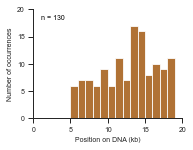

In [27]:
protein = 'T7'
fig,axes = plt.subplots()

sns.distplot(df[~df['t7_terminator']].filter(regex=(protein+'_'),axis=1).filter(regex=("pause_"),axis=1).xs('position_on_dna',level='properties_details',axis=1)/1000,
             ax=axes,color=sns.desaturate(palettes[protein][1],0.75),bins = np.linspace(0, 25, 26),kde=False,hist_kws={"alpha": 1})


axes.set_xlim(0,20)
axes.set_ylim(0,20)
axes.set_xlabel('Position on DNA (kb)')
axes.set_ylabel('Number of occurrences')
#plt.title('Pauses in transcription do not occur at specific sites')

axes.text(0.05, 0.95, f"n = {pd.melt(df[~df['t7_terminator']].filter(regex=('T7_'),axis=1).xs('number_pauses',axis=1,level='properties'))['value'].sum()}",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes,
        color='black')

sns.despine(trim=True)
#plt.tight_layout()

plt.savefig(dir_out+'S2H_Transcription_pause_sites.svg',transparent=True)

### Figure S2I-K: Comparison between different labels
### S2I: Transcription start & stop sites
*Note*: only consider DNA w/o T7T
### S2J: Transcription rates
*Note*: only consider ATP transcription
### S2K: Pause frequency
*Note*: only consider DNA w/o T7T


In [28]:
# estimate standard error by bootstrapping

In [29]:
_plot_df = pd.DataFrame(columns=['label_T7','# of pauses'])
protein = 'T7'

for label in df['label_T7'].unique():
    for num_pause in range(1,int(pd.melt(df[~df['t7_terminator']].filter(regex=("T7_"),axis=1)
                                         .xs('number_pauses',level='properties',axis=1))['value'].max())+1):
        # figure out total nobs
        nobs = len(df[(~df['t7_terminator']) & (df['label_T7']==label)])
        
        _temp_df = pd.DataFrame(data=([nobs]))
        _temp_df.columns = ['nobs']
        _temp_df['label_T7'] = label
        _temp_df['# of pauses'] = num_pause
        
        #if pause available calculate probability
        try:
            #set to value divided by total value
            probability = df[(~df['t7_terminator']) & (df['label_T7']==label)][('T7_1_','number_pauses')].value_counts()[num_pause]/nobs
        #if pause not available set probability to 0 (KeyError)
        except KeyError:
            probability = 0
        _temp_df['probability'] = probability
        
        # bootstrapping
        # generate list with #1 * probability and #0*(1-probability)*dna_number
        bootstrap_data = ([0 for _ in range(int((1-probability)*nobs))] +
                          [1 for _ in range(int(probability*nobs))])
        
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        _temp_df['bs_mean'] = np.mean(bootstrap_means)
        _temp_df['standard_error'] = np.std(bootstrap_means)
        _temp_df['68_ci_lower'], _temp_df['68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
        _temp_df['95_ci_lower'], _temp_df['95_ci_upper'] = calc_ci(bootstrap_means,ci=95)

        _plot_df = pd.concat([_plot_df,_temp_df])
        _plot_df = _plot_df.convert_dtypes()
        _plot_df.reset_index(drop=True,inplace=True)

_plot_df

,label_T7,# of pauses,nobs,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,ybbR-LD555,1,527,0.110057,0.110042,0.013513,0.096774,0.123340,0.083491,0.136622
1,ybbR-LD555,2,527,0.007590,0.007658,0.003820,0.003795,0.011385,0.001898,0.015180
2,ybbR-LD655,1,336,0.136905,0.136880,0.018853,0.119048,0.154762,0.101190,0.175595
3,ybbR-LD655,2,336,0.008929,0.008988,0.005133,0.002976,0.014881,0.000000,0.020833
4,SNAP-AF488,1,129,0.093023,0.092657,0.025513,0.069767,0.116279,0.046512,0.147287
5,SNAP-AF488,2,129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


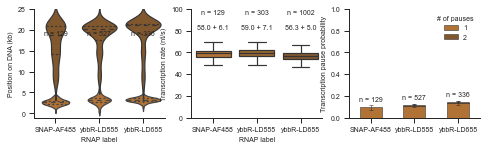

In [30]:
protein = 'T7'

fig,axes = plt.subplots(1,3,figsize=(8,2))

# a) transcription start & stop

sns.violinplot(y=('T7_1_','start_site',''), x='label_T7',
            data=pd.concat([df[~df['t7_terminator']].filter(regex=(protein+'_'),axis=1).xs('start_site',level='properties',axis=1,drop_level=False)/1000,
                            df[~df['t7_terminator']]['label_T7']],axis=1),ax=axes[0],inner='quartile', scale='area',
               order=['SNAP-AF488','ybbR-LD555','ybbR-LD655'],palette=palettes[protein][1:2])

sns.violinplot(y=('T7_1_','stop_site',''), x='label_T7',
            data=pd.concat([df[~df['t7_terminator']].filter(regex=("T7_"),axis=1).xs('stop_site',level='properties',axis=1,drop_level=False)/1000,
                            df[~df['t7_terminator']]['label_T7']],axis=1),ax=axes[0], inner='quartile', scale='area',
               order=['SNAP-AF488','ybbR-LD555','ybbR-LD655'],palette=palettes[protein][3:4])

#axes[0].set_title('Different labels do not affect RNAP transcription stop sites')
axes[0].set_ylim(-1,25)
axes[0].set_yticks([0,5,10,15,20,25])

axes[0].set_xlabel('RNAP label')
axes[0].set_ylabel('Position on DNA (kb)')

# change edgelinecolor
# axes[0].collections[0].set_edgecolor(palettes['AF488'][0])
# axes[0].collections[1].set_edgecolor(palettes['LD555'][0])
# axes[0].collections[2].set_edgecolor(palettes['LD655'][0])
# axes[0].collections[3].set_edgecolor(palettes['AF488'][0])
# axes[0].collections[4].set_edgecolor(palettes['LD555'][0])
# axes[0].collections[5].set_edgecolor(palettes['LD655'][0])

#calculate number of observations
nobs = df[~df['t7_terminator']]['label_T7'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes[0].get_xticklabels()):
    axes[0].text(pos[tick], 20, nobs[tick],
    horizontalalignment='center',verticalalignment='top')

    
# b) transcription rate

sns.boxplot(y='velocity_T7', x='label_T7',data=df[df['nucleotide']=='ATP'], ax=axes[1],
           order=['SNAP-AF488','ybbR-LD555','ybbR-LD655'], palette=palettes[protein][1:],
           flierprops=dict(marker='o',markersize=0))

axes[1].artists
#axes.set_xlim(0,100)
axes[1].set_ylim(0,100)
axes[1].set_xlabel('RNAP label')
axes[1].set_ylabel('Transcription rate (nt/s)')
#axes.legend(loc=0,frameon=False)

# change edgelinecolor
# axes[1].artists[0].set_edgecolor(palettes['AF488'][0])
# axes[1].artists[1].set_edgecolor(palettes['LD555'][0])
# axes[1].artists[2].set_edgecolor(palettes['LD655'][0])

#calculate number of observations
nobs = df[df['nucleotide']=='ATP']['label_T7'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes[1].get_xticklabels()):
    axes[1].text(pos[tick], 100, nobs[tick],
    horizontalalignment='center',verticalalignment='top')

rates = []
# fit data to normal distribution and print on plot
for label in sorted(df[df['nucleotide']=='ATP']['label_T7'].unique()):
    mu, std = norm.fit(df[(df['nucleotide']=='ATP') & (df['label_T7']==label)]['velocity_T7'])
    rates.append(f'{round(mu,1)} + {round(std,1)}')
    
for tick,label in zip(pos,axes[1].get_xticklabels()):
    axes[1].text(pos[tick], 80, rates[tick],
    horizontalalignment='center',verticalalignment='bottom')
    
#axes[1].set_title('Different labels do not affect RNAP transcription')


# c) pausing probability

# plot
_plot_df.groupby(['label_T7','# of pauses'])['probability'].sum().unstack().loc[
    ['SNAP-AF488','ybbR-LD555','ybbR-LD655']].plot(kind='bar',width=0.5,stacked=True, ax=axes[2],lw=0.5, edgecolor='.15',
                                                                                       color=[sns.desaturate(palettes[protein][1],0.75),sns.desaturate(palettes[protein][3],0.75)],
                                                                                       error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                                                                                       yerr=_plot_df.groupby(['label_T7','# of pauses'])['standard_error'].sum().unstack())
axes[2].set_ylim(0,1)
axes[2].set_xlabel(None)
axes[2].set_ylabel('Transcription pause probability')
axes[2].legend(title='# of pauses',frameon=False)
for item in axes[2].get_xticklabels():
    item.set_rotation(0)

labels = _plot_df.loc[(4,0,2),'nobs']

#calculate y offset to label bars on top
dy = _plot_df.loc[(4,0,2),'probability']

rects = axes[2].patches
counter = 0
for rect, label in zip(rects, labels):
    height = dy.iloc[counter]
    axes[2].text(rect.get_x() + rect.get_width()/2, height+0.05, s=f"n = {label}", ha='center', va='bottom')
    counter+=1
       
sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S2I-K_Comparison_different_labels.svg',transparent=True)